### <font color='blue'>チャンカの開発と評価</font>

今まで、どのようにチャンカを評価すれば良いか説明してきていない。<br>
評価には、適切に注釈のつけられたコーパスが必要になる。<br>
そこでIBOフォーマットをNLTKの木構造に変換する仕組みと、チャンキングされたコーパスを利用して<br>
それを大規模に行うにはどのようにしたら良いかをみる。<br>

まずは、チャンカのあるコーパスにおける相対的な正解率を算出する方法。<br>
続いてNPチャンクの検索に用いるさらにいくつかのデータ駆動型の手法。<br>
その間にチャンカの適用範囲を広げる。<br>

### <font color='blue'>IOB フォーマットと CoNLL-2000 チャンキングコーパスの読み込み</font>

変換関数chunk.conllstr2tree()には、以下のIBOフォーマットから<br>
木構造を構築することができる。<br>

In [1]:
text = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''

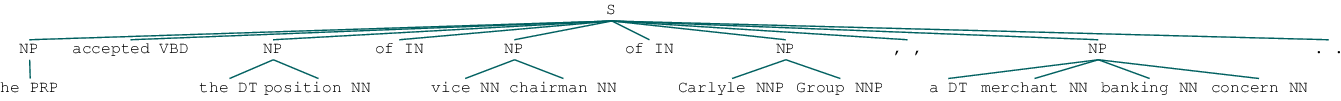

In [4]:
import nltk

# 以下ではNPチャンクのみを指定している
nltk.chunk.conllstr2tree(text, chunk_types=['NP'])

CoNLL-2000チャンキングコーパスは、ウォールストリート・ジャーナルのテキストの27万個の単語を含んでいる。<br>
これを訓練とテストの２つに分け、IBOフォーマットで品詞タグとチャンクタグをつける。<br>

In [5]:
# ウォールストリート・ジャーナルのコーパスのimport
from nltk.corpus import conll2000

In [7]:
# コーパスの訓練データの100番目の文を表示
print(conll2000.chunked_sents('train.txt')[99])

(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


上記からチャンキングコーパスには<br>
NPチャンク、VPチャンク、PPチャンクの３つのチャンクタイプを含んでいる。<br>

In [8]:
# 表示するチャンクタイプの指定
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


### <font color='blue'>簡単な評価とベースライン</font>

チャンキングされたコーパスを読み込んで、チャンカを評価する。<br>

まずは、全くチャンクを生成しない非常に単純なチャンク構文解析器cpをベースラインとして定める。<br>

In [9]:
# コーパスのimport
from nltk.corpus import conll2000

In [10]:
# チャンカの作成
cp = nltk.RegexpParser("")

In [11]:
# テストデータとして、NPチャンクのみの抜き出し
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

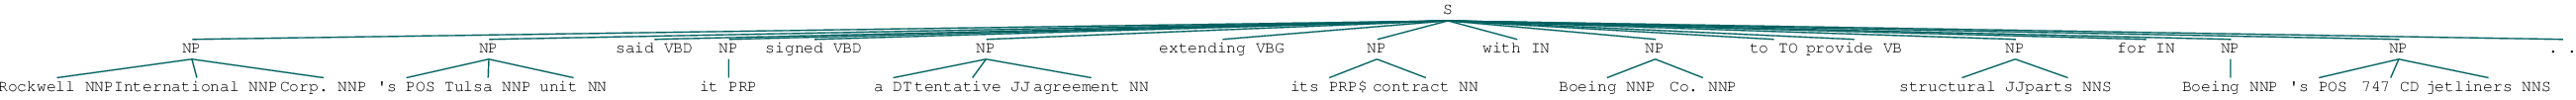

In [13]:
# 表示
test_sents[0]

In [14]:
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


上記のIOBタグの正解率の値が意味するのは、1/3以上の単語にOタグが付与されていること。<br>
つまりNPチャンクではないということ<br>
ただし、このタガーはチャンクを全く見つけていないということに注意。<br>

名詞タグを特徴的に表す文字で始まるタグを発見する、単純な正規表現チャンカを使う。<br>

In [16]:
# チャンキング文法
# CD、DT、JJを特徴的に表す文字で始まるタグを発見する
grammar = r"NP: {<[CDJNP].*>+}"

In [17]:
# チャンキング文法の構築
cp = nltk.RegexpParser(grammar)

In [18]:
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


結果から、上記のチャンカでも比較的ちゃんとした結果を示す。<br>
しかし、よりデータ駆動型のアプローチを追加することで、この結果をさらに改良できる。<br>

訓練コーパスを利用して、(I、B、Oのいずれか)を探す。<br>
別の言い方をすると、ユニグラムタガーを利用して、チャンカを構築する。<br>
ただし、ユニグラムタガーは、品詞タグを与えて正しいチャンクタグを決定する。<br>